<a href="https://colab.research.google.com/github/tanishqtrivedi27/AdversarialAudioClassification/blob/main/resNet%26VGGforESC50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset Loader**

In [ ]:
from torch.utils.data import Dataset
import torch
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

class ESCDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, device):
        self.device = device
        self.transformation = transformation
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir

        self.c2i={}
        self.i2c={}
        self.categories = sorted(self.annotations['category'].unique())
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, _ = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)

        self.transformation.to(device)

        mel_spectrogram = self.transformation(signal)

        # [1, 128, 431] -> [1, 128, 432]
        # Pad one additional frequency bin to the last dimension
        mel_spectrogram = torch.nn.functional.pad(mel_spectrogram, (0, 1))

        mel_spectrogram_db = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)
        mel_spectrogram_db = torch.clamp((mel_spectrogram_db - mel_spectrogram_db.min()) / (mel_spectrogram_db.max() - mel_spectrogram_db.min()), 0, 1) * 255

        return mel_spectrogram_db, label


    def _get_audio_sample_path(self, index):
        filename = self.annotations.iloc[index, 0]
        path = os.path.join(self.audio_dir, filename)
        return path

    def _get_audio_sample_label(self, index):
        return self.c2i[self.annotations.iloc[index, 3]]

    def plot_waveform(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        waveform, sample_rate = torchaudio.load(audio_sample_path)
        waveform = waveform.numpy()

        num_channels, num_frames = waveform.shape
        time_axis = torch.arange(0, num_frames) / sample_rate

        plt.plot(time_axis, waveform[0], linewidth=1)
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.title("Waveform")
        plt.show()

    def plot_mel_spectrogram(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        waveform, sample_rate = torchaudio.load(audio_sample_path)

        mel_transform = T.MelSpectrogram(sample_rate=sample_rate, n_fft=2048, hop_length=512)
        mel_spectrogram = mel_transform(waveform)
        mel_spectrogram_db = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)
        mel_spectrogram_db = torch.clamp((mel_spectrogram_db - mel_spectrogram_db.min()) / (mel_spectrogram_db.max() - mel_spectrogram_db.min()), 0, 1) * 255

        plt.imshow(mel_spectrogram_db[0].numpy(), cmap='viridis', aspect='auto', origin='lower')
        plt.xlabel('Time')
        plt.ylabel('Mel Frequency')
        plt.title('Mel Spectrogram')
        plt.colorbar(format='%+2.0f dB')
        plt.show()

In [ ]:
import torchaudio.transforms as T
from google.colab import drive

drive.mount('/content/drive')
ANNOTATIONS_FILE = "/content/drive/MyDrive/data/ESC-50-master/ESC-50-master/meta/esc-50.csv"
AUDIO_DIR = "/content/drive/MyDrive/data/ESC-50-master/ESC-50-master/audio"

SAMPLE_RATE=44100

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')

mel_transform = T.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=2048, hop_length=512)

esc = ESCDataset(ANNOTATIONS_FILE, AUDIO_DIR, mel_transform, device)

print(f"Total number of samples present in dataset: {len(esc)}")

Mounted at /content/drive
Using device: cuda
Total number of samples present in dataset: 400


**Function to train the model and calculate metrics**

In [ ]:
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
import seaborn as sns

# function to train the model
def train_model(model, dataset, learning_rate=2e-4, num_epochs=10, batch_size=128, stepSize=10, gamma=0.1):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = StepLR(optimizer, step_size=stepSize, gamma=gamma)

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        for batch_input, batch_target in data_loader:
            batch_input, batch_target = batch_input.to(device), batch_target.to(device)
            predictions = model(batch_input)
            loss = loss_fn(predictions, batch_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"  Training Loss: {loss.item()}")

    print("Training finished.")


# function to calculate metrics
def calculate_metrics(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_input, batch_target in data_loader:
            batch_input, batch_target = batch_input.to(device), batch_target.to(device)
            predictions = model(batch_input)
            all_predictions.extend(predictions.argmax(dim=1).cpu().numpy())
            all_targets.extend(batch_target.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')
    accuracy = accuracy_score(all_targets, all_predictions)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(all_targets, all_predictions)
    # Plot the confusion matrix using Seaborn
    sns.heatmap(cm, annot=True)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

**Resnet18 Model**

In [ ]:
from torchvision.models import resnet18

resnet_model = resnet18(weights='DEFAULT')
resnet_model.fc = nn.Linear(512,10)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

Epoch 1/10
  Training Loss: 0.900921106338501
Epoch 2/10
  Training Loss: 0.505273163318634
Epoch 3/10
  Training Loss: 0.5966532826423645
Epoch 4/10
  Training Loss: 0.4500117003917694
Epoch 5/10
  Training Loss: 0.20579278469085693
Epoch 6/10
  Training Loss: 0.3308820128440857
Epoch 7/10
  Training Loss: 0.23391114175319672
Epoch 8/10
  Training Loss: 0.12456196546554565
Epoch 9/10
  Training Loss: 0.10757098346948624
Epoch 10/10
  Training Loss: 0.09611792117357254
Training finished.
Accuracy: 95.75%
Precision: 0.9634
Recall: 0.9575
F1 Score: 0.9565


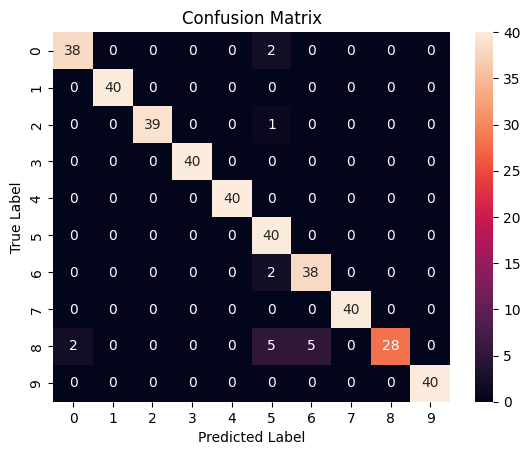

In [ ]:
train_model(resnet_model, esc, learning_rate=2e-4, num_epochs=10, batch_size=128)

data_loader = DataLoader(esc, batch_size=128, shuffle=True)
calculate_metrics(resnet_model, data_loader, device)

**Resnet34 model**

In [ ]:
from torchvision.models import resnet34

resnet34_model = resnet34(weights='DEFAULT')
resnet34_model.fc = nn.Linear(512,10)
resnet34_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet34_model = resnet34_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 167MB/s]


Epoch 1/10
  Training Loss: 0.7738224267959595
Epoch 2/10
  Training Loss: 1.257484793663025
Epoch 3/10
  Training Loss: 0.31742265820503235
Epoch 4/10
  Training Loss: 0.23765304684638977
Epoch 5/10
  Training Loss: 0.2928570806980133
Epoch 6/10
  Training Loss: 0.4679581820964813
Epoch 7/10
  Training Loss: 0.2672562897205353
Epoch 8/10
  Training Loss: 0.06260122358798981
Epoch 9/10
  Training Loss: 0.1274866759777069
Epoch 10/10
  Training Loss: 0.06534604728221893
Training finished.
Accuracy: 97.00%
Precision: 0.9730
Recall: 0.9700
F1 Score: 0.9698


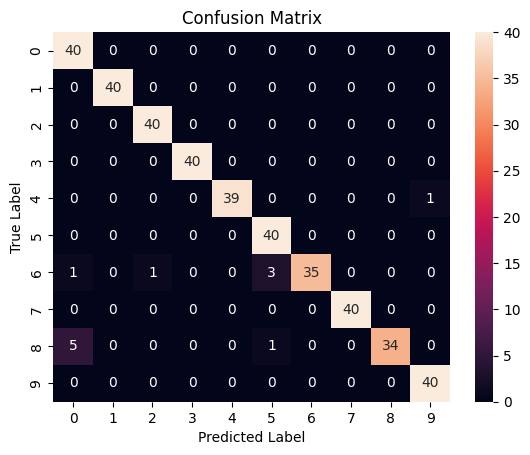

In [ ]:
train_model(resnet34_model, esc, learning_rate=2e-4, num_epochs=10, batch_size=128)

data_loader = DataLoader(esc, batch_size=128, shuffle=True)
calculate_metrics(resnet34_model, data_loader, device)

**VGG16**

In [ ]:
from torchvision.models import vgg16
import torch.nn as nn

vgg_model = vgg16(weights='IMAGENET1K_V1')
vgg_model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg_model.classifier[6] = nn.Linear(4096, 10)
vgg_model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 83.1MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch 1/40
  Training Loss: 1.2546489238739014
Epoch 2/40
  Training Loss: 1.7232775688171387
Epoch 3/40
  Training Loss: 1.0369952917099
Epoch 4/40
  Training Loss: 0.8534731864929199
Epoch 5/40
  Training Loss: 0.6944787502288818
Epoch 6/40
  Training Loss: 0.9754260182380676
Epoch 7/40
  Training Loss: 0.483503520488739
Epoch 8/40
  Training Loss: 0.9357717633247375
Epoch 9/40
  Training Loss: 0.6596745252609253
Epoch 10/40
  Training Loss: 3.733992338180542
Epoch 11/40
  Training Loss: 1.0603396892547607
Epoch 12/40
  Training Loss: 1.0769680738449097
Epoch 13/40
  Training Loss: 1.0538970232009888
Epoch 14/40
  Training Loss: 0.8098939061164856
Epoch 15/40
  Training Loss: 0.5945940017700195
Epoch 16/40
  Training Loss: 0.5864242911338806
Epoch 17/40
  Training Loss: 0.3877473771572113
Epoch 18/40
  Training Loss: 0.46900781989097595
Epoch 19/40
  Training Loss: 0.8285076022148132
Epoch 20/40
  Training Loss: 0.3868846297264099
Epoch 21/40
  Training Loss: 0.5787956118583679
Epoch

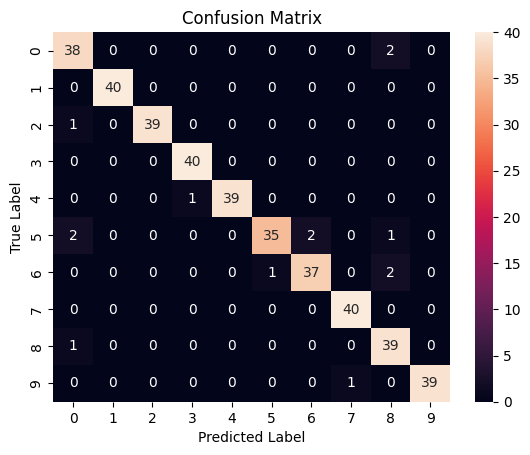

In [ ]:
train_model(vgg_model, esc, learning_rate=2e-4, num_epochs=40, batch_size=64)

data_loader = DataLoader(esc, batch_size=128, shuffle=True)
calculate_metrics(vgg_model, data_loader, device)

**Audio MLP Mixer**

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install mlp-mixer-pytorch

In [ ]:
from mlp_mixer_pytorch import MLPMixer

mlpmodel = MLPMixer(
    image_size = (128, 432),
    channels = 1,
    patch_size = 16,
    dim = 512,
    depth = 12,
    num_classes = 10
)

mlpmodel.to(device)

Sequential(
  (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
  (1): Linear(in_features=256, out_features=512, bias=True)
  (2): Sequential(
    (0): PreNormResidual(
      (fn): Sequential(
        (0): Conv1d(216, 864, kernel_size=(1,), stride=(1,))
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Conv1d(864, 216, kernel_size=(1,), stride=(1,))
        (4): Dropout(p=0.0, inplace=False)
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (1): PreNormResidual(
      (fn): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (3): Sequential(
    (0): PreNormResidual(
      (fn): Sequentia

Epoch 1/40
  Training Loss: 0.6915531158447266
Epoch 2/40
  Training Loss: 1.3352892398834229
Epoch 3/40
  Training Loss: 1.303797721862793
Epoch 4/40
  Training Loss: 1.5152392387390137
Epoch 5/40
  Training Loss: 1.2170770168304443
Epoch 6/40
  Training Loss: 1.2502491474151611
Epoch 7/40
  Training Loss: 1.0358673334121704
Epoch 8/40
  Training Loss: 0.8690328001976013
Epoch 9/40
  Training Loss: 1.061218023300171
Epoch 10/40
  Training Loss: 1.453303337097168
Epoch 11/40
  Training Loss: 0.8158233761787415
Epoch 12/40
  Training Loss: 0.7445403933525085
Epoch 13/40
  Training Loss: 1.0552706718444824
Epoch 14/40
  Training Loss: 0.8082330822944641
Epoch 15/40
  Training Loss: 0.8631454110145569
Epoch 16/40
  Training Loss: 0.7406578660011292
Epoch 17/40
  Training Loss: 0.8633581399917603
Epoch 18/40
  Training Loss: 0.5923246741294861
Epoch 19/40
  Training Loss: 0.9103550910949707
Epoch 20/40
  Training Loss: 0.6993634700775146
Epoch 21/40
  Training Loss: 0.7002750635147095
Epoc

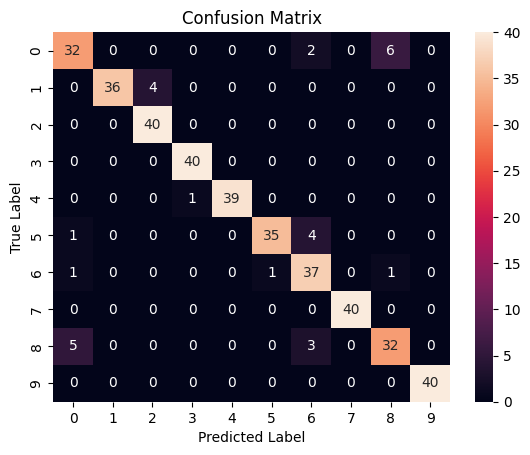

In [ ]:
train_model(mlpmodel, esc, learning_rate=2e-4, num_epochs=40, batch_size=64)

data_loader = DataLoader(esc, batch_size=128, shuffle=True)
calculate_metrics(mlpmodel, data_loader, device)

In [ ]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstal